In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import nltk

from nlu_engine import NLUEngine
from nlu_engine import MacroDataRefinement
from nlu_engine import MacroEntityRefinement

from nlu_engine import DataUtils
from nlu_engine import RenderJSON

from nlu_engine import Analytics

from nlu_engine import EntityExtractor, crf

# Macro NLU Data Refinement

It's a bit like the TV show [Serverance](https://www.imdb.com/title/tt11280740/) .

![Helly R and Mark S](https://media.npr.org/assets/img/2022/02/15/atv_severance_photo_010103-5f8033cc2b219ba64fe265ce893eae4c90e83896-s1100-c50.jpg "Helly R and Mark G")

*Helly R*: `My job is to scroll through the spreadsheet and look for the numbers that feel scary?`

*Mark S*: `I told you, you’ll understand when you see it, so just be patient.`

![MDR](https://www.imore.com/sites/imore.com/files/styles/large/public/field/image/2022/03/refinement-software-severance-apple-tv.jpg "serverance micro data refinement")

*Helly R*: `That was scary. The numbers were scary.`

Hopefully the intents and entities that are wrong aren't scary, just a bit frustrating. Let's see if we can find the right ones.

NOTE: We will use Logistic Regression with TFIDF features to train our intent models and CRFs for entity exraction. Why? Well, they are very fast and both methods aren't state-of-the-art. This is good, because it is easier to find problems we will need to refine in the dataset than if we were to use a proper NLU engine like Snips or something SOTA like BERT. It is very important to note that some of the the problems we will pick up on, might not be an actual issue, but might be due to the limitations of the models. Refining the real problems and ignoring the limitations of the models is a good way to improve the models. Then when the dataset is ready, we can use some more advanced NLU engine and get the best performance possible.

* Macro NLU Data Refinement: Intent
* Macro NLU Data Refinement: Entity


Load the dataset

In [2]:
try:
    nlu_data_refined_df = pd.read_csv(
        'data/refined/nlu_data_intent_and_entity_refined_df.csv', index_col=0)
    print('Successfully loaded nlu_data_intent_and_entity_refined_df.csv')
    removed_nlu_data_refined_df = nlu_data_refined_df[nlu_data_refined_df['remove'] != True]
except:
    nlu_data_refined_df = pd.read_csv(
        'data/refined/nlu_data_refined_df.csv', sep=',', index_col=0)
    print('Successfully loaded nlu_data_refined_df.csv')
    
    nlu_data_refined_df = DataUtils.convert_annotated_utterances_to_normalised_utterances(
        nlu_data_refined_df)

    removed_nlu_data_refined_df = nlu_data_refined_df[nlu_data_refined_df['remove'] != True]


Successfully loaded nlu_data_intent_and_entity_refined_df.csv


In [ ]:
nlu_data_refined_df

In [ ]:
#TODO: does this NEED to be here, LOL!
from matplotlib.pyplot import axis

We should remove the unwanted entries for the next few steps.

# Entity extraction reports

The entity extraction could be greatly improved by improving the features it uses. It would be great if someone would take a look at this. Perhaps the CRF features similar to what Snips uses would be better such as Brown clustering (probably).

In [ ]:
#TODO: implement brown clustering to improve entity extraction (see entity_extractor.py)

It is important to have the NLTK tokenizer to be able to extract entities.

In [ ]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
        nltk.download('punkt')

Due to this error featured in [this git issue](https://github.com/TeamHG-Memex/sklearn-crfsuite/issues/60) we have to use an older version of scikit learn (sklearn<0.24), otherwise the latest version would work. Hopefully this gets fixed one day..

In [3]:
# try to load entity_report.csv
try:
    entity_report_df = pd.read_csv(
        'data/reports/entity_report.csv')
    print('Successfully loaded entity_report.csv')
except:
    entity_report_df = NLUEngine.evaluate_entity_classifier(
        data_df=removed_nlu_data_refined_df, cv=4)

Successfully loaded entity_report.csv


In [ ]:
entity_report_df

In [ ]:
# export entity_report_df to csv
entity_report_df.to_csv(
    'data/reports/entity_report.csv',
    index=False)

Let's have a look at the report plotted for us

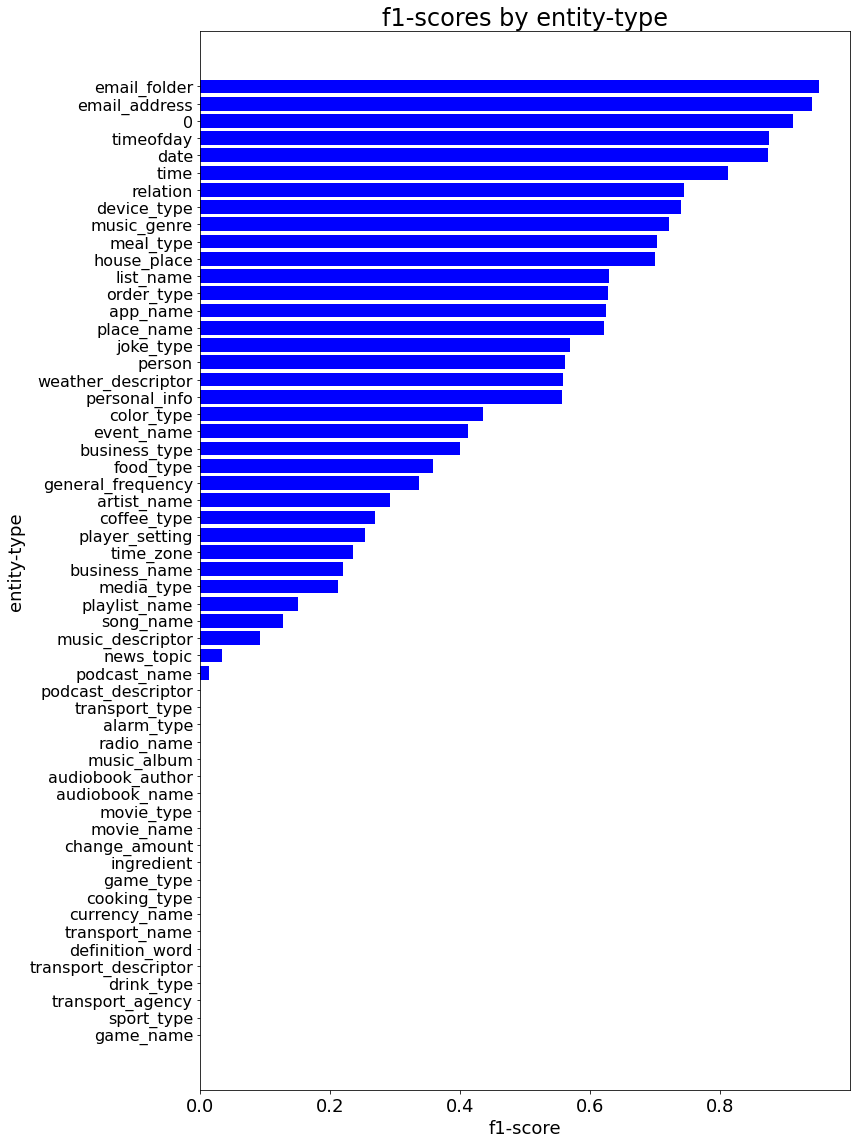

In [4]:
Analytics.plot_report(entity_report_df)

We will need to extract out the entity types from the dataset. We need this to calculate the precentage of entities, to filter out any domains that have too few entities for benchmarking by domain instead of all domains together.

In [5]:
nlu_data_refined_df['entities'] = nlu_data_refined_df['answer_annotation'].apply(
    EntityExtractor.extract_entities)

nlu_data_refined_df['entity_types'] = nlu_data_refined_df['entities'].apply(
    EntityExtractor.extract_entity_types)

import numpy as np
nlu_data_refined_df['entity_types'] = nlu_data_refined_df['entity_types'].apply(lambda y: np.nan if len(y)==0 else y)
nlu_data_refined_df['entities'] = nlu_data_refined_df['entities'].apply(lambda y: np.nan if len(y)==0 else y)

In [ ]:
nlu_data_refined_df

In [6]:
removed_nlu_data_refined_df = nlu_data_refined_df[nlu_data_refined_df['remove'] != True]

In [ ]:
domain_entity_reports_df = NLUEngine.get_entity_reports_for_domains(removed_nlu_data_refined_df)

In [ ]:
domain_entity_reports_df = domain_entity_reports_df[domain_entity_reports_df['entity-type'].str.contains(
    'weighted avg')].sort_values(by='f1-score', ascending=True)

In [ ]:
domain_entity_reports_df

In [ ]:
domain_entity_reports_df.to_csv('data/reports/domain_entity_reports.csv', index=False)

In [7]:
domain_entity_reports_df = pd.read_csv('data/reports/domain_entity_reports.csv')

In [ ]:
import matplotlib.pyplot as plt

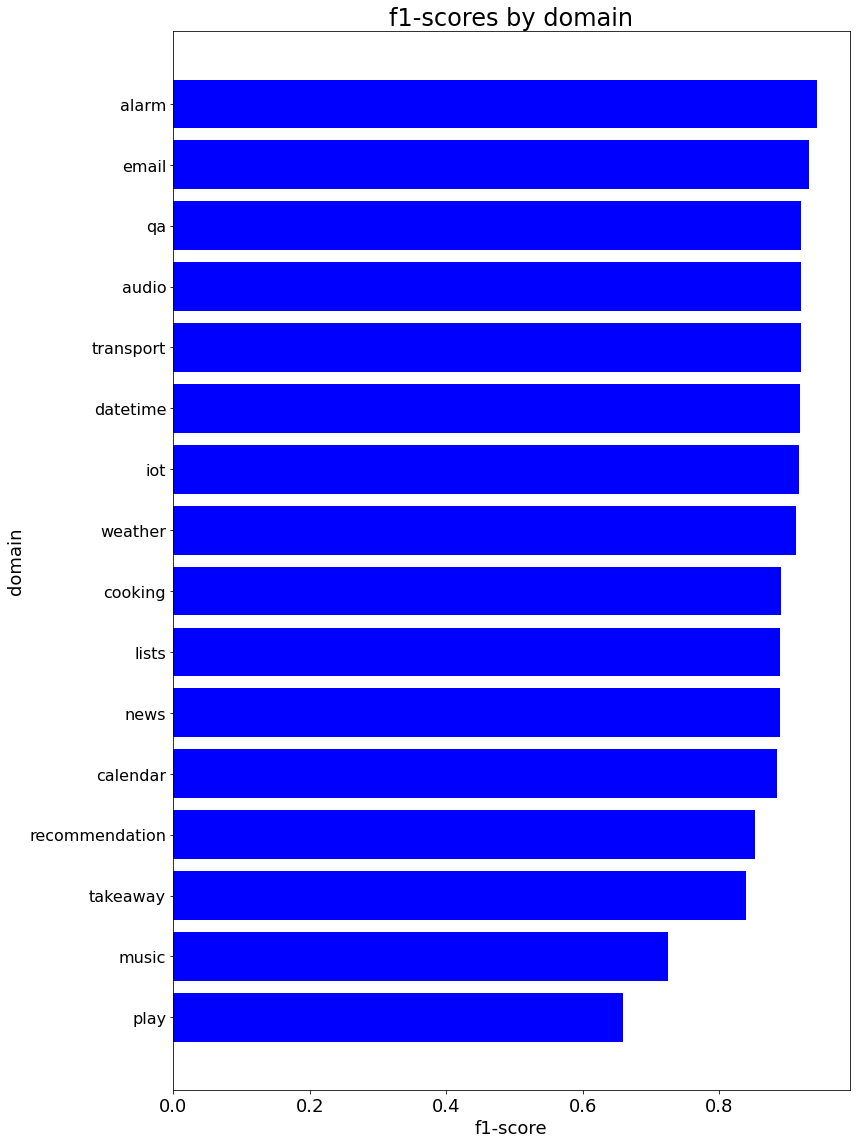

In [8]:
label = domain_entity_reports_df.columns[5]
Analytics.plot_entity_report(domain_entity_reports_df, label)

## entity classification 

We can get the `predicted_tagging` and find all of the entities that are being incorrectly classified.

If you don't already have a saved model (for the default data set there is already one), you can train a model and save it.

In [ ]:
crf_model = NLUEngine.train_entity_classifier(removed_nlu_data_refined_df)

In [ ]:
model_path = 'models/analytics/entity_tagger.sav'

In [ ]:
DataUtils.pickle_model(classifier=crf_model, model_path=model_path)

You can open it from here.

In [9]:
model_path = 'models/analytics/entity_tagger.sav'

In [10]:
crf_model = DataUtils.import_pickled_model(model_path)

Now, let's run it across our data set to get the `predicted_tagging`.

In [11]:
nlu_data_refined_df['predicted_tagging'] = nlu_data_refined_df['answer_normalised'].apply(
    lambda x: NLUEngine.create_entity_tagged_utterance(x, crf_model))

In [12]:
removed_nlu_data_refined_df = nlu_data_refined_df[nlu_data_refined_df['remove'] != True]

We can now load a dataset of all of the incorrectly predicted entities.

In [ ]:
#TODO: I might move this out since it is only being done after the overlapping entities have been removed
incorrect_predicted_entities_df = removed_nlu_data_refined_df[removed_nlu_data_refined_df['answer_annotation']
                            != removed_nlu_data_refined_df['predicted_tagging']]

In [ ]:
incorrect_predicted_entities_df

# Domain specific entity analysis

For a new domain start here!

Pick a domain to start.

In [13]:
domain_selection = MacroDataRefinement.list_and_select_domain(
    removed_nlu_data_refined_df)

In [14]:
domain_df = DataUtils.get_domain_df(
    removed_nlu_data_refined_df, domain_selection)

Successfully loaded dataframe


In [ ]:
domain_df

Incorrectly predicted entities report

In [15]:
incorrect_predicted_entities_report = MacroEntityRefinement.get_incorrect_predicted_entities_report(
    domain_df, entity_report_df, domain_entity_reports_df)

Entity type: player_setting
Correct entities: 1
Incorrect entities: 0
Total entities: 1
Entity type: relation
Correct entities: 0
Incorrect entities: 1
Total entities: 1
Entity type: business_name
Correct entities: 0
Incorrect entities: 1
Total entities: 1
Entity type: date
Correct entities: 4
Incorrect entities: 1
Total entities: 5
Entity type: timeofday
Correct entities: 1
Incorrect entities: 0
Total entities: 1
Entity type: house_place
Correct entities: 261
Incorrect entities: 39
Total entities: 300
Entity type: place_name
Correct entities: 0
Incorrect entities: 1
Total entities: 1
Entity type: time
Correct entities: 28
Incorrect entities: 14
Total entities: 42
Entity type: business_type
Correct entities: 0
Incorrect entities: 2
Total entities: 2
Entity type: color_type
Correct entities: 126
Incorrect entities: 19
Total entities: 145
Entity type: person
Correct entities: 1
Incorrect entities: 0
Total entities: 1
Entity type: device_type
Correct entities: 305
Incorrect entities: 47
T

Let's have a better look at this report of incorrectly predicted entities.

In [ ]:
RenderJSON(incorrect_predicted_entities_report)

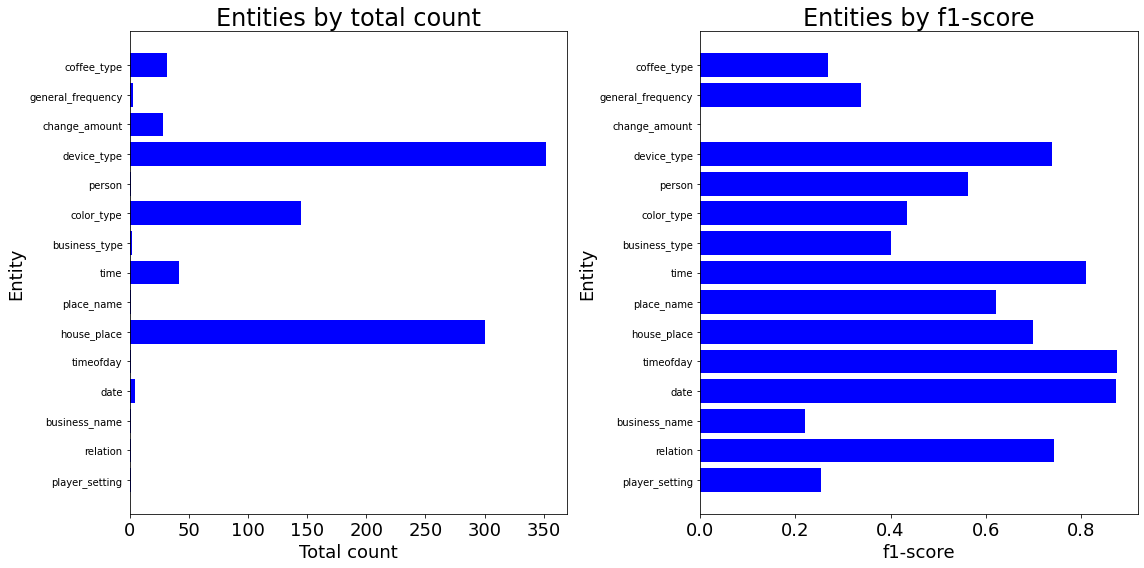

In [16]:
incorrect_entity_types, incorrect_entity_counts = Analytics.plot_incorrect_entities_by_count_and_f1_score(
    incorrect_predicted_entities_report)

## Refine sparse entity types

In this step, we will look at the sparse entity types that are labeled incorrect in the domain and select the ones we want to remove or untag.

In [ ]:
#TODO: add this to a method

In [ ]:
entity_types_and_counts = zip(incorrect_entity_types, incorrect_entity_counts)

In [ ]:
# arrange the entities in entity_types by total count in ascending order
entity_types_and_counts = sorted(entity_types_and_counts, key=lambda x: x[1])

# create a list of the entities in entity_types in ascending order of total count
entity_types = [entity_type for entity_type, count in entity_types_and_counts]

# create a list of the total counts of the entities in entity_types in ascending order of total count
entity_counts = [count for entity_type, count in entity_types_and_counts]

# refactor above code to be more compact


In [ ]:
sorted_entity_types = [entity_type for entity_type, count in sorted(
    zip(entity_types, entity_counts), key=lambda x: x[1])]
sorted_entity_counts = [count for entity_type, count in sorted(
    zip(entity_types, entity_counts), key=lambda x: x[1])]
sorted_entity_types_and_counts = zip(
    sorted_entity_types, sorted_entity_counts)

In [ ]:
# From sorted_entity_types get all entities with less than 5 total count and output a dataframe of entries in domain_df with those entities

def get_entries_with_sparse_total(domain_df, sorted_entity_types_and_counts):
    entity_types_with_sparse_total = []
    entity_counts_with_sparse_total = []
    for entity_type, entity_count in sorted_entity_types_and_counts:
        if entity_count < 5:
            print(f'Entity type: {entity_type}, Total count: {entity_count}')
            entity_types_with_sparse_total.append(entity_type)
            entity_counts_with_sparse_total.append(entity_count)
    if len(entity_types_with_sparse_total) > 0:
        sparse_total_df = pd.DataFrame(
            {
                'entity_type': entity_types_with_sparse_total,
                'total_count': entity_counts_with_sparse_total
                })
        sparse_entity_entries_df = domain_df[domain_df['entity_types'].str.contains(
            ('|').join(entity_types_with_sparse_total), na=False)]
        return sparse_total_df, sparse_entity_entries_df
    else: 
        return None


In [ ]:
sparse_total_df, sparse_entries_df = get_entries_with_sparse_total(
    domain_df, sorted_entity_types_and_counts)
# create a ipysheet for sparse_total_df with boolean buttons for merge, remove, untag
# Should the merge be multiple buttons, one for each entity type to merge with?
sparse_entries_df

In [17]:
sparse_total_df, sparse_entries_df = MacroEntityRefinement.get_entries_with_sparse_total(
    domain_df, incorrect_entity_types, incorrect_entity_counts)

Entity type: player_setting, Total count: 1
Entity type: relation, Total count: 1
Entity type: business_name, Total count: 1
Entity type: timeofday, Total count: 1
Entity type: place_name, Total count: 1
Entity type: person, Total count: 1
Entity type: business_type, Total count: 2
Entity type: general_frequency, Total count: 3


In [18]:
import ipysheet

In [19]:
def create_sparse_entity_review_sheet(sparse_total_df):
    '''
    Create a sheet with the entity types and total counts of entities with boolean columns for whether the entity should be removed, merged, or untagged
    :param sparse_total_df: a dataframe with the entity types and total counts of entities with less than 5 total count
    :return: an ipysheet with the entity types and total counts of entities with boolean columns for whether the entity should be removed, merged, or untagged
    '''

    to_review_df = sparse_total_df.copy()
    to_review_df = to_review_df.assign(remove=None)
    to_review_df['remove'] = to_review_df['remove'].astype('bool')
    to_review_df = to_review_df.assign(merge=None)
    to_review_df['merge'] = to_review_df['merge'].astype('bool')
    to_review_df = to_review_df.assign(untag_entity=None)
    to_review_df['untag_entity'] = to_review_df['untag_entity'].astype('bool')
    return ipysheet.from_dataframe(to_review_df)


In [20]:
sparse_entity_review_sheet = create_sparse_entity_review_sheet(sparse_total_df)
sparse_entity_review_sheet

Sheet(cells=(Cell(column_end=0, column_start=0, numeric_format=None, row_end=7, row_start=0, squeeze_row=False…

In [21]:
# FROM HERE
#TODO: Clean up notebook!
def get_sparse_entries_by_type(sparse_entries_df):
    entity_types = sparse_total_df['entity_type'].tolist()
    entity_type_index_dict = {
        entity_type: index for index, entity_type in enumerate(entity_types)}
    number_choice = input(
        'Enter the number of the entity type you want to look at: ')
    entity_type = entity_types[int(number_choice)]

    return sparse_entries_df[sparse_entries_df['entity_types'].str.contains(entity_type, na=False)]


In [23]:
get_sparse_entries_by_type(sparse_entries_df)

,question,answer_normalised,scenario,intent,predicted_label,answer_annotation,entities,entity_types,predicted_tagging
2291,Write what you would tell your PDA in the foll...,turn on my son's room plug socket on off,iot,wemo_on,wemo_on,turn on my [relation : son's] [house_place : r...,"[{'type': 'relation', 'words': ['son's']}, {'t...","relation,house_place,device_type",turn on my son's [house_place : room] [device_...


In [ ]:
#TODO: add a function to remove entries marked for removal
#TODO: add a function to untag entities marked for untagging
#TODO: add a function to merge entities?

In [ ]:
# I am not sure if this part is necessary

In [ ]:
def split_entity_types(domain_df):
    '''
    Split entity types by , and group entries by split entity types
    :param domain_df: a dataframe with entries in the entity_types column
    :return: a dataframe with entries grouped by entity type
    '''
    split_entity_types_df = domain_df.copy()
    split_entity_types_df['entity_types'] = split_entity_types_df['entity_types'].str.split(
        ',')
    split_entity_types_df = split_entity_types_df.explode(
        'entity_types').reset_index(drop=True)
    return split_entity_types_df

In [ ]:
# create multi index from sparse_entries_df with frame with the split entity_types and the answer_annotation as the sub column

split_entity_types_df = split_entity_types(sparse_entries_df)

split_entity_types_df = split_entity_types_df[['intent', 'entity_types', 'answer_annotation', 'predicted_tagging']]
split_entity_types_df

# TODO: make the entity_type the index and then group all of the answer_annotations by entity_type and then count the number of each answer_annotation
# Do I need to use a multi index for this?
pd.MultiIndex.from_frame(split_entity_types_df)


In [ ]:
entity_types

In [ ]:
split_entity_types_df = create_entity_type_df(sparse_entries_df)
split_entity_types_df

In [ ]:
# TODO: the entries should be arranged in the same order as the entity types in sparse_total_df
# TODO: add use predicted tagging column as boolean?
# TODO: make df that only has intent, predicted label, answer annotation, predicted tagging
df = sparse_entries_df[['intent', 'predicted_label', 'answer_annotation', 'predicted_tagging']]

# display the entire columns for answer_annotation and predicted_tagging
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

In [ ]:
#TODO: From here we will want to create an ipysheet of the above, and allow the user to select entries to remove or if there is an entity from the list to be untagged or merged:
# Option 1: Remove entry
# Option 2: Merge entry (how to get which one?)
# Option 3: Untag entry (how to get which one?)

In [ ]:
# TODO: place_name -> house_place
# Add in ability to change a whole entity type to another. e.g. place_name -> house_place

## Entity overlap refinement
We want to find the entities that have overlapping entity types. Entities (the words themselves that get tagged), should very rarely have more than one entity type in a domain. If they do, then we need to refine the dataset.

take the `domain_df['entities']` and get a list of dictionaries for:
* `id`: the original index of the row
* `entity_type`: the entity type
* `entity_words`: the joined words with spaces that make up the entity

and then drop it into a dataframe

In [ ]:
correct_entity_types, incorrect_entity_types, overlapping_entity_words = MacroEntityRefinement.pick_correct_entity_type_for_overlapping_entities(
    domain_df)

    #TODO: add option to just press enter to skip picking a correct entity type (i.e. coffee type black but color black)

We have the `correct_entity_types`. We will need those to know what to change the `entity_type` to.

In [ ]:
correct_entity_types

We should probably get a list of the `incorrect_entity_types` to go along with our `correct_entity_types`, so we know what to replace.

In [ ]:
incorrect_entity_types

How about we for loop over the zip of `incorrect_entity_types` and `correct_entity_types` and replace the `entity_type` in `overlapping_domain_df` with the `correct_entity_type`.

In [ ]:
refined_overlapping_domain_df = MacroEntityRefinement.refine_overlapping_entity_types(
    domain_df, correct_entity_types, incorrect_entity_types, overlapping_entity_words)

## Entity refinement
We will want to refine all of the entries that have the incorrect entity types.

In [ ]:
domain_incorrect_predicted_entities_df = refined_overlapping_domain_df[refined_overlapping_domain_df['answer_annotation']
                                                              != refined_overlapping_domain_df['predicted_tagging']]


In [ ]:
to_review_sheet = MacroDataRefinement.create_sheet(
    domain_incorrect_predicted_entities_df)
to_review_sheet

In [ ]:
to_review_sheet

In [ ]:
# TODO: start from here, refine then save to CSV the changes. Repeat until all domains have been refined.

In [ ]:
reviewed_domain_entities_df = MacroDataRefinement.convert_sheet_to_dataframe(to_review_sheet)

In [ ]:
refined_domain_entities_df = reviewed_domain_entities_df.apply(
    MacroDataRefinement.replace_annotated_utterance_with_predicted_tagging, axis=1)

In [ ]:
refined_domain_entities_df.to_csv(
    f'data/refined/entities/{domain_selection}_refined_entities_df.csv')

In [ ]:
refined_domain_entities_df = MacroDataRefinement.mark_entries_as_refined(
    refined_dataframe=refined_domain_entities_df, refined_type='entity')

In [ ]:
nlu_data_refined_df.update(refined_domain_entities_df)

In [ ]:
removed_nlu_data_refined_df = nlu_data_refined_df[nlu_data_refined_df['remove'] != True]

In [ ]:
nlu_data_refined_df.to_csv(
    f'data/refined/nlu_data_intent_and_entity_refined_df.csv')

In [ ]:
# FROM HERE: loop back for each domain to refine the entities until done.

In [ ]:
# TODO: once all of the refinements of each domain have been completed the nlu_data_refined_df should be updated with the refined data from removed_nlu_data_refined_df!
# Don't forget: The removed entries are no longer in the removed_nlu_data_refined_df so they need to be added back into the nlu_data_refined_df from the files!

In [ ]:
nlu_data_df = pd.read_csv(
    'data/refined/nlu_data_refined_df.csv', sep=',', index_col=0)

In [ ]:
nlu_data_df = DataUtils.convert_annotated_utterances_to_normalised_utterances(
    nlu_data_df)

In [ ]:
import glob

In [ ]:
# load and concat all csv files in the data/refined/entities folder
path = 'data/refined/entities'
all_files = glob.glob(path + "/*.csv")

df = pd.concat((pd.read_csv(f, index_col=0)
               for f in all_files))


In [ ]:
refined_df = MacroDataRefinement.mark_entries_as_refined(
    refined_dataframe=df, refined_type='entity')


In [ ]:
refined_df = refined_df[refined_df['scenario'] != 'iot']


In [ ]:
nlu_data_df.update(refined_df)

In [ ]:
nlu_data_df.to_csv('data/refined/nlu_data_intent_and_entity_refined_df.csv')
#FROM HERE!
#TODO use this for the flow from the start instead of the removed_nlu_data_refined_updated_df!
#TODO: test this on the flow and make sure it works before going to refinement
#TODO: change after the report on entities with JSON to get a simple output of all the entities in the domain and examples like in the report but have the user see if any entities need to be totally removed as labels or merged with others before continuing to the refinement stage!

In [ ]:
#TODO: refactor intent refinement to dump the csvs into a sub dir called intents!

In [ ]:
#TODO: It is probably a good idea to drop all of the ones that lack a good support.
#NOTE: But it didn't work to fix the problem.
remove_entities = [
    'music_album',
    'game_type',
    
]
removed_nlu_data_refined__entities_cleaned_df = removed_nlu_data_refined_df[~removed_nlu_data_refined_df['answer_annotation'].str.contains('|'.join(remove_entities))]

In [ ]:
Analytics.plot_report(entity_report_df)

In [ ]:
#TODO: Remove/replace worst: add in state features like here: https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#let-s-check-what-classifier-learned
# Specifically, we want print_state_features()

In [ ]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))


In [ ]:
from nlu_engine import crf
from collections import Counter

In [ ]:
crf_model.state_features_

In [ ]:
print_state_features(Counter(crf.state_features_).most_common(100))

In [ ]:
# TODO: review the most common features, none of them are the word parts (chunks) or POS tags, are these even needed or helpful?
# Can we remove them and speed up the process?
# What other features could be used? Word2vec? Brown clustering?

In [ ]:
domain_selection = MacroDataRefinement.list_and_select_domain(nlu_data_df)

As we have seen from the entity extraction report, the entity extraction is not working for the alarm_type.

In [ ]:
#TODO: review all scoring 0, see if they can be completely dropped or what
entity_to_refine = 'alarm_type'
nlu_scenario_df = removed_nlu_data_refined_df[removed_nlu_data_refined_df['answer_annotation'].str.contains(
    entity_to_refine)]

In [ ]:
nlu_scenario_df

In [ ]:
def remove_entity(df, entity_to_remove):
    """
        Remove all entries of an entity type from the dataframe.
        :param df: pandas dataframe
        :return: pandas dataframe
        """
    updated_df = df.copy()
    updated_df.loc[updated_df['answer_annotation'].str.contains(
        entity_to_remove), 'remove'] = True
    return updated_df


In [ ]:
updated_df = remove_entity(removed_nlu_data_refined_df, entity_to_refine)

In [ ]:
removed_nlu_data_refined_df[removed_nlu_data_refined_df['answer_annotation'].str.contains(
    entity_to_refine)]

## Entity Convert to ipysheet and review
TODO: add in description of the types of fixes we can do to the NLU data for entity


In [ ]:

# TODO: same as above for intents but with predicted entities: report on them, break them down into a dictionary of dataframes and refine them..

For the example with 'alarm' and the alarm_type:
* We see that the alarm_type entities are really event_name(ie wake up, soccer practice) except for ID 5879, we will need to change them to event_name and remove ID 5879.
* The last one(ID 6320) is a mistake. Someone got confused with the prompt and assumed alarm is a security system. This is out of scope for the alarm domain, as the alarms are ones set on a phone or other device. We will drop this utterance.
Once you are done reviewing, you convert it back to a dataframe and check to make sure it looks okay.
Let's change all alarm_type entities to event_name.

In [ ]:

reviewed_scenario_df['answer_annotation'] = reviewed_scenario_df['answer_annotation'].str.replace(
    'alarm_type', 'event_name')
reviewed_scenario_df


Okay dokey, now we can merge this with the original data set and see if it made a difference already(well of course it did!).

In [ ]:
nlu_data_df.drop(
    reviewed_scenario_df[reviewed_scenario_df['remove'] == True].index, inplace=True)

reviewed_scenario_df = reviewed_scenario_df[~reviewed_scenario_df['remove'] == True]

nlu_data_df.loc[nlu_data_df.index.intersection(
    reviewed_scenario_df.index), 'answer_annotation'] = reviewed_scenario_df['answer_annotation']

nlu_data_df[(nlu_data_df['scenario'].str.contains('alarm')) & (nlu_data_df['answer_annotation'].str.contains(
    'event_name'))]


### Benchmark changed data set
TODO: repeat reports for the changed data set for domain and entities and compare


In [ ]:

entity_reviewed_report_df = NLUEngine.evaluate_entity_classifier(
    data_df=nlu_data_df)
entity_reviewed_report_df.sort_values(by=['f1-score'])

If you are sure it is okay, you can save it as a csv file, make sure to name it correctly(i.e. `alarm_domain_first_review.csv`)

In [ ]:
reviewed_scenario_df.to_csv('alarm_domain_first_review.csv')

Load it back up and check to make sure it looks okay. Make sure to give it the right name!


In [ ]:
audio_domain_first_review_df = pd.read_csv(
    'alarm_domain_first_review.csv', index_col=0)
audio_domain_first_review_df.tail(50)


In [ ]:
# TODO: implement the evaluate_classifier in the NLU engine to check f1 score for intents and entities in the domain vs original NLU data of domain!
# Value: benchmark!
#TODO: implement a flow for getting the domains with the lowest f1 scores by intent/domain and entities and cleaning them by the order of the lowest f1 scores
# TODO: concat all reviewed dfs and save to csv
# TODO: add benchmark for whole NLU data set before and after cleaning! (by intents and domains!)
# TODO: review the review marked entries
# TODO: add new column for notes
# TODO: change flow of review for only ones that should be reviewed, not all of the ones that have been changed (track changes by comparing against the original data set)
# TODO: do the changed utterances have to be changed in other fields too or is it just enough for the tagged utterancve field?
# TODO: add visualizations of domains, their intents, keywords in utterances, and entities to top
